In [1]:
import mujoco
import mujoco_viewer
import copy as cp
import matplotlib.pyplot as plt
from control.mppi_gait import MPPI
import numpy as np

In [2]:
import mujoco_viewer

In [3]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [4]:
import os

In [5]:
model_sim = mujoco.MjModel.from_xml_path("models/go1/go1_scene_mppi.xml")

In [6]:
model_sim.actuator('FR_hip').biasprm

array([  0., -60.,  -3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [7]:
model_sim.actuator('FL_calf').gainprm

array([60.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [8]:
dt_sim = 0.01
model_sim.opt.timestep = dt_sim
data_sim = mujoco.MjData(model_sim)

In [9]:
viewer = mujoco_viewer.MujocoViewer(model_sim, data_sim, 'offscreen')

In [10]:
# reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 1) # stand position
mujoco.mj_forward(model_sim, data_sim)
q_init = cp.deepcopy(data_sim.qpos) # save reference pose
v_init = cp.deepcopy(data_sim.qvel) # save reference pose

In [11]:
print("Configuration: {}".format(q_init)) # save reference pose

Configuration: [ 0.     0.     0.08   1.     0.     0.     0.     0.073  1.34  -2.83
  0.073  1.34  -2.83   0.073  1.34  -2.83   0.073  1.34  -2.83 ]


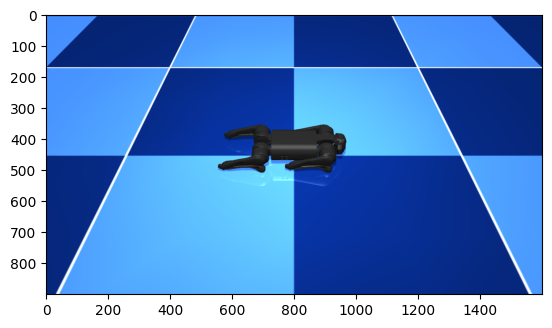

In [12]:
img = viewer.read_pixels()
plt.imshow(img)

In [13]:
model_sim.name_jntadr

array([122, 123, 136, 151, 165, 178, 193, 207, 220, 235, 249, 262, 277],
      dtype=int32)

In [14]:
model_sim.name_actuatoradr

array([624, 631, 640, 648, 655, 664, 672, 679, 688, 696, 703, 712],
      dtype=int32)

In [15]:
model_sim.names

b'Quadruped Go1\x00world\x00trunk\x00FR_hip\x00FR_thigh\x00FR_calf\x00FL_hip\x00FL_thigh\x00FL_calf\x00RR_hip\x00RR_thigh\x00RR_calf\x00RL_hip\x00RL_thigh\x00RL_calf\x00\x00FR_hip_joint\x00FR_thigh_joint\x00FR_calf_joint\x00FL_hip_joint\x00FL_thigh_joint\x00FL_calf_joint\x00RR_hip_joint\x00RR_thigh_joint\x00RR_calf_joint\x00RL_hip_joint\x00RL_thigh_joint\x00RL_calf_joint\x00floor\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00FR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00FL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00RR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00RL\x00head\x00imu\x00FR\x00FL\x00RR\x00RL\x00tracking\x00\x00spotlight\x00trunk\x00hip\x00thigh_mirror\x00calf\x00thigh\x00blue_grid\x00grey_grid\x00skybox\x00blue_grid\x00grey_grid\x00self\x00self_default\x00self_highlight\x00effector\x00effector_default\x00effector_highlight\x00decoration\x00eye\x00target\x00target_default\x00target_highlight\x00site\x00dark\x00FR_hip\x00FR_thigh\x00FR_c

In [16]:
model_sim.njnt

13

In [17]:
def get_joint_names(model):
    names = []
    for i in range(model.njnt-1):
        name_adr = model.name_jntadr[i+1]
        name = model.names[name_adr:].split(b'\x00', 1)[0].decode('utf-8')
        names.append(name)
    return names

In [18]:
# Get actuator names
joint_names = get_joint_names(model_sim)

# Print actuator names
for name in joint_names:
    print(name)

FR_hip_joint
FR_thigh_joint
FR_calf_joint
FL_hip_joint
FL_thigh_joint
FL_calf_joint
RR_hip_joint
RR_thigh_joint
RR_calf_joint
RL_hip_joint
RL_thigh_joint
RL_calf_joint


In [19]:
def get_actuator_names(model):
    names = []
    for i in range(model.nu):
        name_adr = model.name_actuatoradr[i]
        name = model.names[name_adr:].split(b'\x00', 1)[0].decode('utf-8')
        names.append(name)
    return names

# Get actuator names
actuator_names = get_actuator_names(model_sim)

# Print actuator names
for name in actuator_names:
    print(name)

FR_hip
FR_thigh
FR_calf
FL_hip
FL_thigh
FL_calf
RR_hip
RR_thigh
RR_calf
RL_hip
RL_thigh
RL_calf


In [20]:
# reset robot (keyframes are defined in the xml)
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 0) # stand position
mujoco.mj_forward(model_sim, data_sim)
q_ref_mj = cp.deepcopy(data_sim.qpos) # save reference pose
v_ref_mj = cp.deepcopy(data_sim.qvel) # save reference pose

In [21]:
print("Configuration: {}".format(q_ref_mj)) # save reference pose

Configuration: [ 0.    0.    0.26  1.    0.    0.    0.    0.    0.9  -1.8   0.    0.9
 -1.8   0.    0.9  -1.8   0.    0.9  -1.8 ]


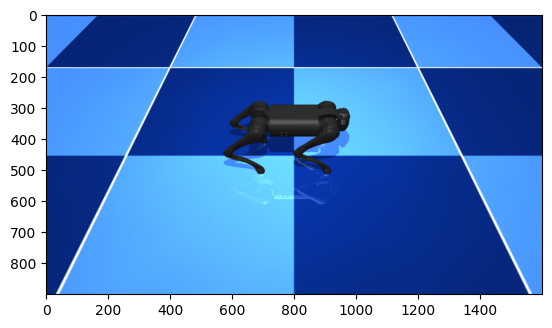

In [22]:
img = viewer.read_pixels()
plt.imshow(img)

In [23]:
controller = MPPI()
controller.internal_ref = True
controller.reset_planner()

In [24]:
q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
x = np.concatenate([q_curr, v_curr])

In [25]:
%%time
controller.update(x)

CPU times: user 115 ms, sys: 1.61 ms, total: 117 ms
Wall time: 28.1 ms


array([-0.3405523 ,  1.23576648, -2.76421665,  0.38879858,  1.29981484,
       -2.80481555, -0.37896256,  1.31086802, -2.78402014,  0.30367718,
        1.44226299, -2.81313532])

In [26]:
controller.reset_planner()

In [27]:
tfinal = 5
tvec = np.linspace(0,tfinal,int(np.ceil(tfinal/dt_sim))+1)

In [28]:
mujoco.mj_resetDataKeyframe(model_sim, data_sim, 1)
mujoco.mj_forward(model_sim, data_sim)

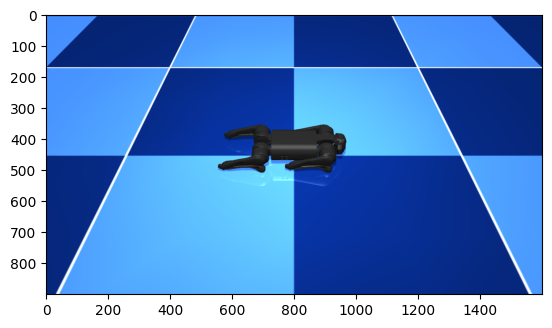

In [29]:
img = viewer.read_pixels()
plt.imshow(img)

In [30]:
%%time
anim_imgs = []
sim_inputs = []
x_states = []
for ticks, ti in enumerate(tvec):
    q_curr = cp.deepcopy(data_sim.qpos) # save reference pose
    v_curr = cp.deepcopy(data_sim.qvel) # save reference pose
    x = np.concatenate([q_curr, v_curr])
    
    if ticks%2 == 0:
        u_joints = controller.update(x)  
        
    data_sim.ctrl[:] = u_joints
    mujoco.mj_step(model_sim, data_sim)
    mujoco.mj_forward(model_sim, data_sim)
    img = viewer.read_pixels()
    anim_imgs.append(img)
    sim_inputs.append(u_joints)
    x_states.append(x)

CPU times: user 23.8 s, sys: 1.21 s, total: 25 s
Wall time: 8 s


In [31]:
x_states_np = np.array(x_states)

In [32]:
x_states_np.shape

(501, 37)

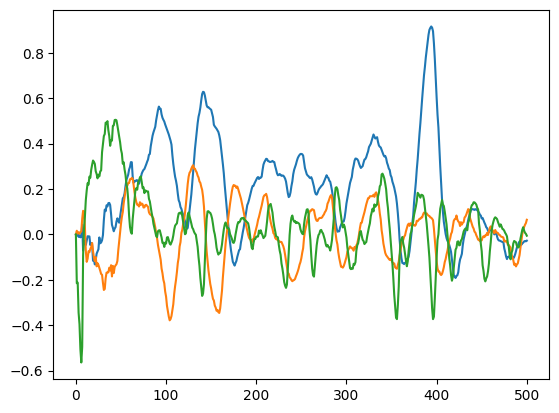

In [33]:
plt.plot(x_states_np[:,19:22])

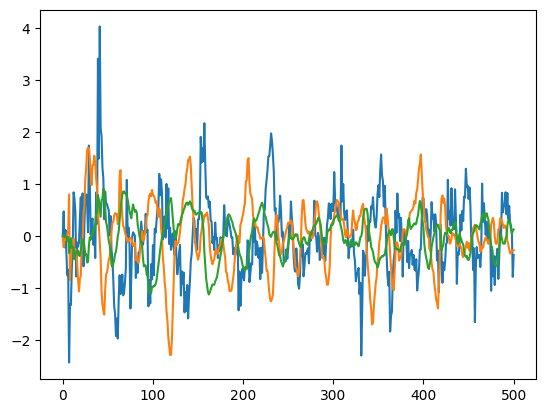

In [34]:
plt.plot(x_states_np[:,22:25])

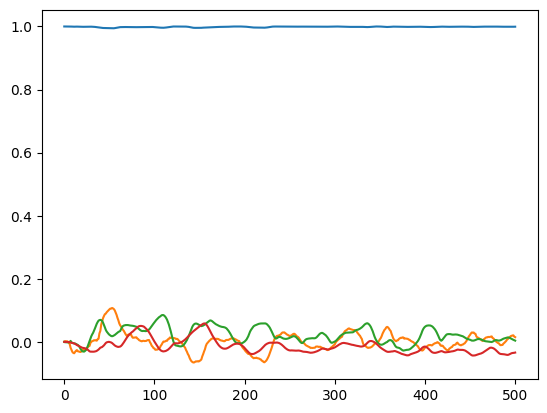

In [35]:
plt.plot(x_states_np[:,3:7])

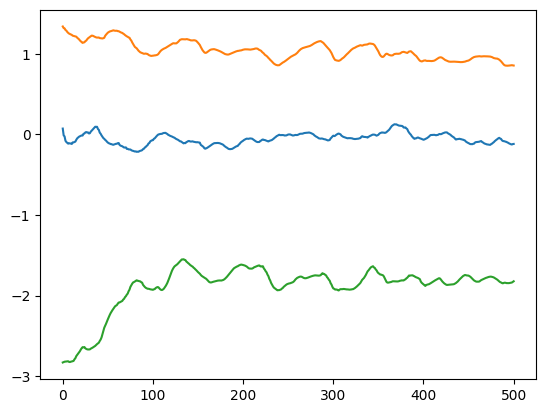

In [36]:
plt.plot(x_states_np[:,7:10])

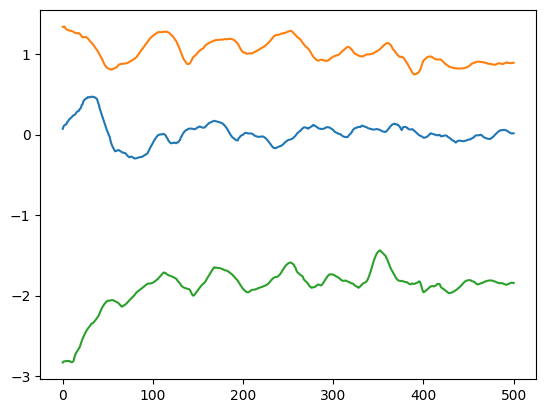

In [37]:
plt.plot(x_states_np[:,10:13])

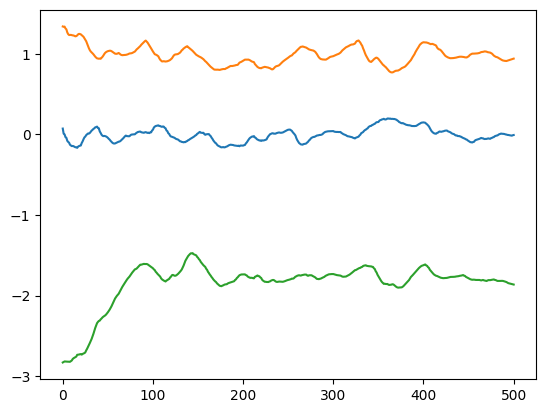

In [38]:
plt.plot(x_states_np[:,13:16])

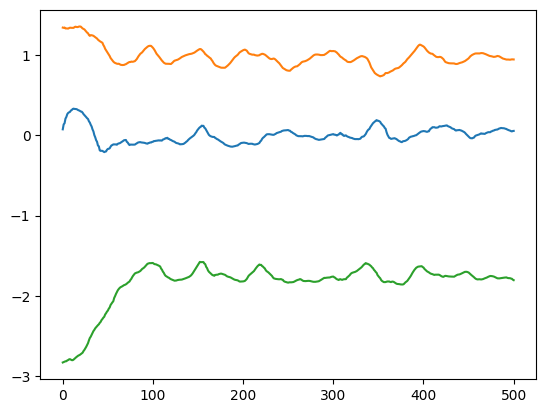

In [39]:
plt.plot(x_states_np[:,16:19])

In [40]:
sim_inputs_np = np.array(sim_inputs)

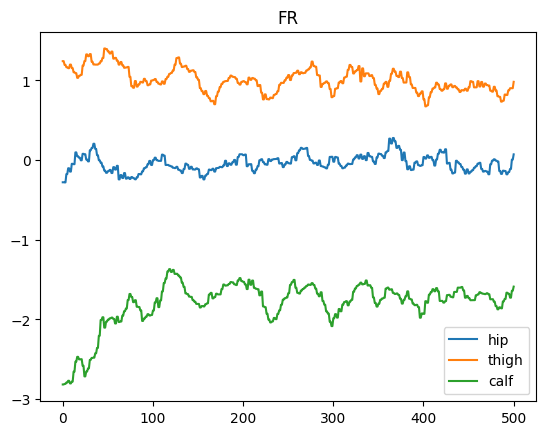

In [60]:
plt.plot(sim_inputs_np[:,0:3], label=["hip", "thigh", "calf"])
plt.title("FR")
plt.legend()

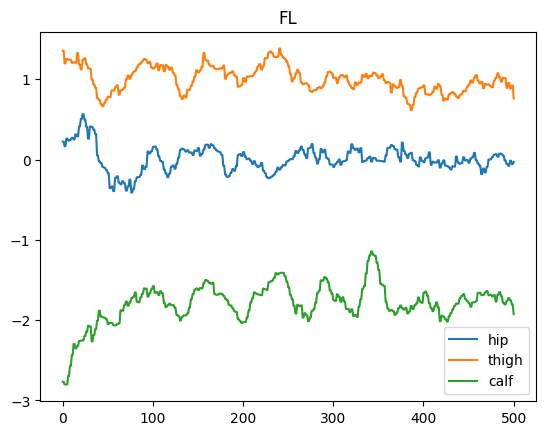

In [61]:
plt.plot(sim_inputs_np[:,3:6], label=["hip", "thigh", "calf"])
plt.title("FL")
plt.legend()

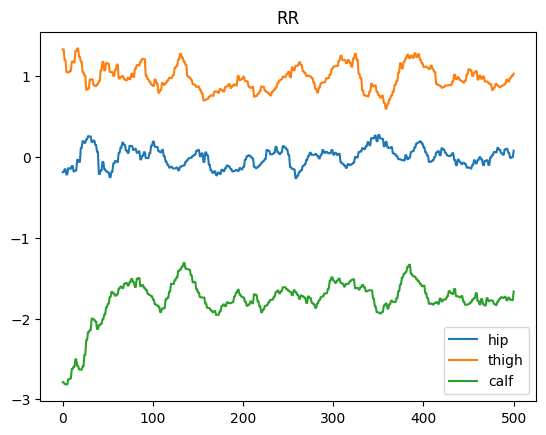

In [62]:
plt.plot(sim_inputs_np[:,6:9], label=["hip", "thigh", "calf"])
plt.title("RR")
plt.legend()

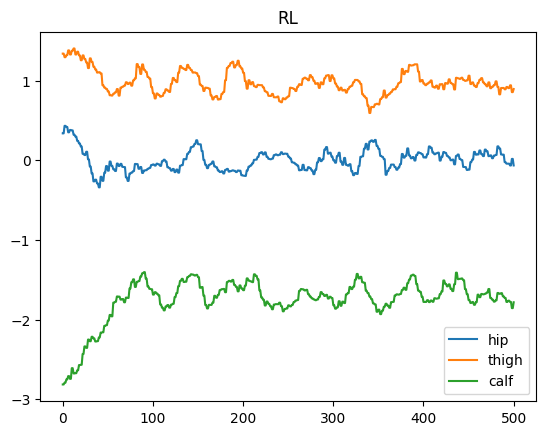

In [63]:
plt.plot(sim_inputs_np[:,9:], label=["hip", "thigh", "calf"])
plt.title("RL")
plt.legend()

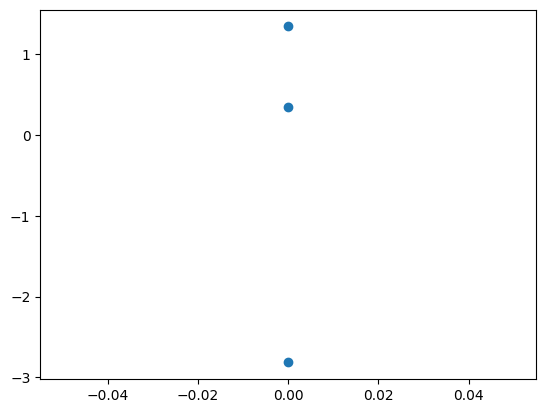

In [44]:
plt.scatter((0,0,0),sim_inputs_np[0,9:12])

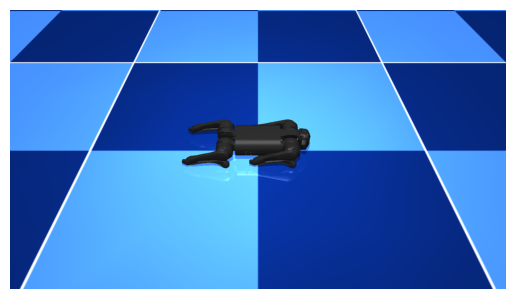

In [45]:
fig, ax = plt.subplots()
skip_frames = 5
interval = dt_sim*1000*skip_frames

def animate(i):
    ax.clear()
    ax.imshow(anim_imgs[i * skip_frames])  # Display the image, skipping frames
    ax.axis('off')

# Create animation, considering the reduced frame rate due to skipped frames
ani = FuncAnimation(fig, animate, frames=len(anim_imgs) // skip_frames, interval=interval)  # 50 ms for 20 Hz

# Display the animation
HTML(ani.to_jshtml())

In [48]:
sim_inputs_np.shape

(501, 12)

In [50]:
np.savetxt('mujoco_logs/walking_straight.tsv', sim_inputs_np, delimiter='\t')